In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Birth Data Analysis") \
    .getOrCreate()

table_path_1718 = "hdfs:///user/abdur_zeybey/data_table_1718"
table_path_1920 = "hdfs:///user/abdur_zeybey/data_table_1920"

 - Reading CSV data, and Save as Table with parquet format. Need once.

In [22]:
data = spark.read.csv(
    "birth_2017.csv",
    header=True,
    inferSchema=True,
)

data.write \
    .mode("overwrite") \
    .parquet(table_path_1718)

data = spark.read.csv(
    "birth_2018.csv",
    header=True,
    inferSchema=True,
)

data.write \
    .mode("append") \
    .parquet(table_path_1718)

data = spark.read.csv(
    "birth_2019.csv",
    header=True,
    inferSchema=True,
)

data.write \
    .mode("overwrite") \
    .parquet(table_path_1920)

data = spark.read.csv(
    "birth_2020.csv",
    header=True,
    inferSchema=True,
)

data.write \
    .mode("append") \
    .parquet(table_path_1920)



In [2]:
ols_cols = [
            "dob_yy",
            "dob_mm",
            "dob_tt",
            "dob_wk",
            "mager",
            "meduc",
            "fagecomb",
            "feduc",
            "cig_0",
            "rf_pdiab",
            "rf_phype",
            "rf_inftr",
            "rf_fedrg",
            "dplural",
            "sex",
            "dbwt",
        ]

new_cols = [
            "DOB_YY",
            "DOB_MM",
            "DOB_TT",
            "DOB_WK",
            "MAGER", #Mother's Age
            "MEDUC", #Mother’s Education
            "FAGECOMB", #Father’s Age
            "FEDUC",  #Father’s Education
            "CIG_0", #Cigarettes Before Pregnancy
            "RF_PDIAB", #Pre-pregnancy Diabetes
            "RF_PHYPE", #Pre-pregnancy Hypertension
            "RF_INFTR", #Infertility Treatment Used
            "RF_FEDRG", #Fertility Enhancing Drugs
            "DPLURAL", #Plurality Recode
            "SEX", #Sex of Infant
            "DBWT", #Birth Weight – Detail in Grams
        ]

In [3]:
data_table_1718 = spark.read.parquet(table_path_1718).select(ols_cols)
data_table_1920 = spark.read.parquet(table_path_1920).select(new_cols)

for old_col, new_col in zip(ols_cols, new_cols):
    data_table_1718 = data_table_1718.withColumnRenamed(old_col, new_col)

data_table = data_table_1718.union(data_table_1920)

data_table.createOrReplaceTempView("data_table")

23/04/14 22:50:23 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
result = spark.sql("SELECT * FROM data_table LIMIT 1")
result.show()

+------+------+------+------+-----+-----+--------+-----+-----+--------+--------+--------+--------+-------+---+----+
|DOB_YY|DOB_MM|DOB_TT|DOB_WK|MAGER|MEDUC|FAGECOMB|FEDUC|CIG_0|RF_PDIAB|RF_PHYPE|RF_INFTR|RF_FEDRG|DPLURAL|SEX|DBWT|
+------+------+------+------+-----+-----+--------+-----+-----+--------+--------+--------+--------+-------+---+----+
|  2018|     3|  1506|     5|   39|    1|      47|    1|    0|       N|       N|       N|       X|      1|  M|4598|
+------+------+------+------+-----+-----+--------+-----+-----+--------+--------+--------+--------+-------+---+----+



In [70]:
result = spark.sql("SELECT count(*) FROM data_table")
result.show()

+--------+
|count(1)|
+--------+
|15043753|
+--------+



In [60]:
result = spark.sql("SELECT CIG_0, count(*) FROM data_table GROUP BY CIG_0")
result.show()

+-----+--------+
|CIG_0|count(1)|
+-----+--------+
|   31|      40|
|   85|      10|
|   65|      10|
|   28|      82|
|   76|       2|
|   27|      73|
|   26|     117|
|   44|      12|
|   12|   12005|
|   22|     250|
|   47|       3|
|    1|   37174|
|   13|    1175|
|    6|   36616|
|   16|     708|
|    3|   60067|
|   20|  357024|
|   40|   36395|
|   96|       2|
|   48|      51|
+-----+--------+
only showing top 20 rows



In [5]:
birth_weight_stats = data_table.select("DBWT").summary()
birth_weight_stats.show()

+-------+-----------------+
|summary|             DBWT|
+-------+-----------------+
|  count|         15043696|
|   mean|3264.251856591625|
| stddev|620.8752988930911|
|    min|              227|
|    25%|             2960|
|    50%|             3300|
|    75%|             3629|
|    max|             9999|
+-------+-----------------+



In [12]:
from pyspark.sql.functions import mean, col, count


avg_birth_weight_by_age = data_table.groupBy("MAGER").agg(mean(col("DBWT")).alias("AVG_BIRTH_WEIGHT"))
avg_birth_weight_by_age = avg_birth_weight_by_age.sort("MAGER")
avg_birth_weight_by_age.show()

+-----+------------------+
|MAGER|  AVG_BIRTH_WEIGHT|
+-----+------------------+
|   12|2991.2928870292885|
|   13| 3014.312661498708|
|   14| 3071.156899810964|
|   15| 3099.763986013986|
|   16| 3122.331346982123|
|   17|3132.6918455356267|
|   18| 3143.793142312638|
|   19|3163.9167867841147|
|   20|3182.7157530826084|
|   21|3198.5838051191304|
|   22|3217.0949763288386|
|   23|3231.4137766923413|
|   24|3243.9156310837816|
|   25| 3256.493322108593|
|   26| 3266.149936453677|
|   27|3273.7471977600353|
|   28|3285.1547281721905|
|   29|3290.7004716559677|
|   30| 3294.353377484834|
|   31| 3300.308895296542|
+-----+------------------+
only showing top 20 rows



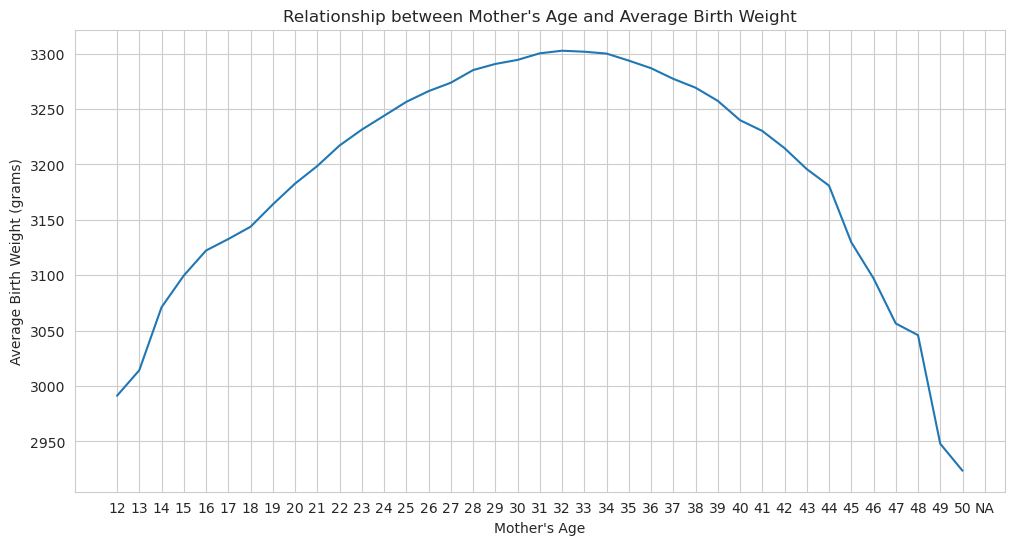

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


avg_birth_weight_by_age_pd = avg_birth_weight_by_age.toPandas()

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_birth_weight_by_age_pd, x="MAGER", y="AVG_BIRTH_WEIGHT")
plt.title("Relationship between Mother's Age and Average Birth Weight")
plt.xlabel("Mother's Age")
plt.ylabel("Average Birth Weight (grams)")
plt.show()

In [8]:
grouped_data = data_table.groupBy("MEDUC", "FEDUC") \
                          .agg(mean(col("MAGER")).alias("AVG_MOTHER_AGE"))

# Sort the data by mother's and father's education levels
grouped_data = grouped_data.sort("MEDUC", "FEDUC")
grouped_data.show()

+-----+-----+------------------+
|MEDUC|FEDUC|    AVG_MOTHER_AGE|
+-----+-----+------------------+
|    1|    1| 30.45087331408297|
|    1|    2|29.998656415615436|
|    1|    3| 29.73849232821881|
|    1|    4|29.933118262648517|
|    1|    5|30.434736563410112|
|    1|    6|30.717539026629936|
|    1|    7| 31.25811823480433|
|    1|    8| 32.04081632653061|
|    1|    9|27.026244132672907|
|    2|    1|29.005683863718186|
|    2|    2| 25.79438688051301|
|    2|    3| 25.18942871697405|
|    2|    4| 26.51174456469687|
|    2|    5| 27.96489010989011|
|    2|    6|29.362193548387097|
|    2|    7|30.225611510791367|
|    2|    8| 30.52403282532239|
|    2|    9|23.926162840265512|
|    3|    1|28.625125274537815|
|    3|    2| 25.88484846901043|
+-----+-----+------------------+
only showing top 20 rows



Education Levels : 

1 8th grade or less
2 9th through 12th grade with no diploma
3 High school graduate or GED completed
4 Some college credit, but not a degree.
5 Associate degree (AA,AS)
6 Bachelor’s degree (BA, AB, BS)
7 Master’s degree (MA, MS, MEng, MEd, MSW, MBA)
8 Doctorate (PhD, EdD) or Professional Degree (MD, DDS)
9 Unknown

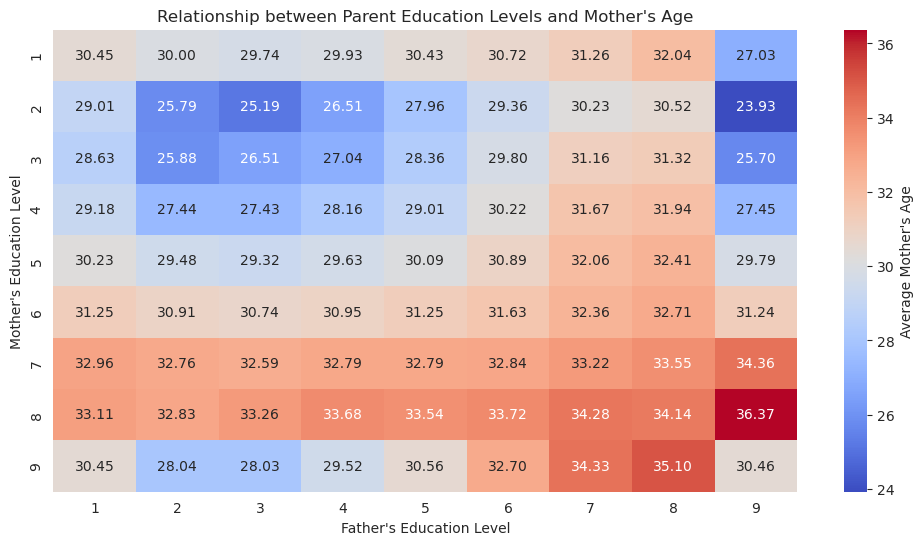

In [10]:

# Convert the Spark DataFrame to a Pandas DataFrame
grouped_data_pd = grouped_data.toPandas()

# Create a pivot table with MEDUC and FEDUC as indexes and AVG_MOTHER_AGE as values
pivot_table = grouped_data_pd.pivot_table(index="MEDUC", columns="FEDUC", values="AVG_MOTHER_AGE")

# Set the plot style
sns.set_style("whitegrid")

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Average Mother's Age"})
plt.title("Relationship between Parent Education Levels and Mother's Age")
plt.xlabel("Father's Education Level")
plt.ylabel("Mother's Education Level")
plt.show()

In [13]:
# Group data by month (DOB_MM) and count the number of births
monthly_births = data_table.groupBy("DOB_MM").agg(count("*").alias("NUM_BIRTHS"))

# Sort the data by month
monthly_births = monthly_births.sort("DOB_MM")
monthly_births.show()

+------+----------+
|DOB_MM|NUM_BIRTHS|
+------+----------+
|  null|        57|
|     1|   1247404|
|     2|   1138698|
|     3|   1244481|
|     4|   1190621|
|     5|   1263679|
|     6|   1247635|
|     7|   1322173|
|     8|   1361409|
|     9|   1300511|
|    10|   1290215|
|    11|   1208664|
|    12|   1228206|
+------+----------+



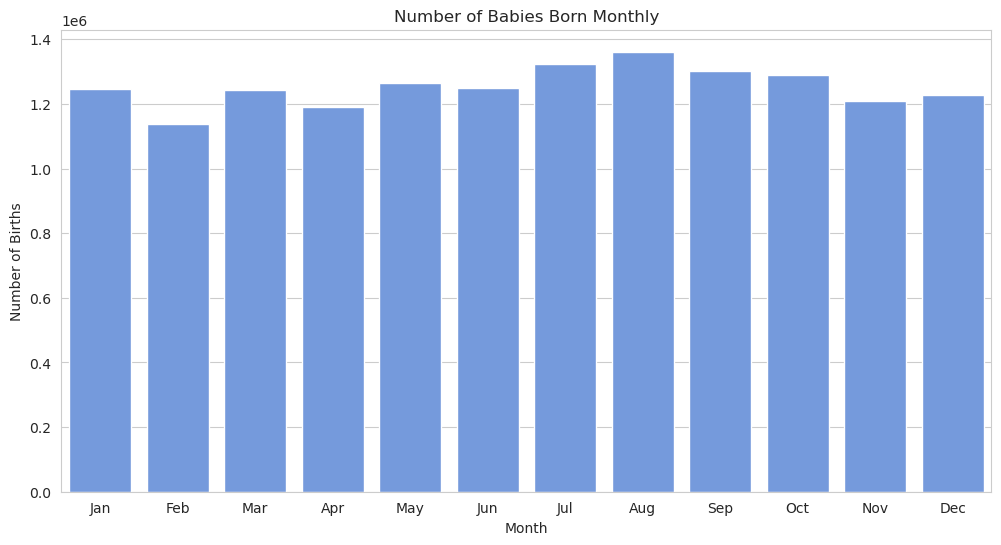

In [14]:
monthly_births_pd = monthly_births.toPandas()

# Set the plot style
sns.set_style("whitegrid")

# Plot the number of babies born monthly
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_births_pd, x="DOB_MM", y="NUM_BIRTHS", color="cornflowerblue")
plt.title("Number of Babies Born Monthly")
plt.xlabel("Month")
plt.ylabel("Number of Births")
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()